**Objective**

- Create a scatter plot and visually decide if a linear model is appropriate (a matrix scatter plot will would be most efficient).

* If the relation is not linear, transform the data accordingly (i.e Box-Cox transformation)
 
* Create an OLS model for the original and transformed data if required. 
 - Evaluate if the OLS assumptions are met: normality of errors centered around zero, equal variance, etc..., for the original data and transformed data if appropriate. 

 - Comment how the transformation impacted the different assumptions. (This should be done only by looking at the output diagnostic charts created by the software)
 
 - If datasets have outliers, remove the outliers and see the effect in the model (slope, intercept and R-square)


## Conclusions at the very bottom starting at "Answers and Conclusions" header. 
## Everything before are functions used to determine "Answers and Conclusions"

In [1]:
import pandas as pd
import numpy as np
import collections
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
# parse sheets into 
xl = pd.ExcelFile('linear_regression_data.xlsx')

In [3]:
def create_dfs(xl):    
    # create a dictionary for multiple spreedsheets

    dfs = {}  # empty dict for multiple spreedsheets
    dfs_add = {}

    # loop sheet names and contents into the dict
    for sheet in xl.sheet_names:
        dfs[f'{sheet}'] = pd.read_excel(xl, sheet)

        # rename column labels, necessary for later
        if dfs[f'{sheet}'].columns.any() == 'y':
            conv_sheet = sheet                                       # save sheets with improper headers
            conv_df = dfs[f'{sheet}'].rename(columns = {'y' : 'Y'})  # rename the headers
            dfs_add[f'{conv_sheet}'] = conv_df                       # combine the key - value pairs  

        else:
            conv_sheet = sheet                                       # save sheets with improper headers
            conv_df = dfs[f'{sheet}'].rename(columns = {'X' : 'x'})  # rename the headers
            dfs_add[f'{conv_sheet}'] = conv_df                       # combine the key - value pairs  

    dfs.update(dfs_add)     # modifies dfs with dfs_add's keys and values & returns None
    
    return dfs

# Visual Linearity Check:

In [4]:
# check for linearity of the spreedsheets by creating 
# scatter matrix plots for each sheet to visually 
# decide if a linear model is appropriate

# a function that determines the correlation matrix for each set
def corr_matr(df):
    cm = {}

    for i, (k, v) in enumerate(df.items(), start = 1):
        cm.setdefault(f'{k}', [])
        cm[f'{k}'].append(v.corr(method = 'pearson'))

    return cm

In [5]:
# a function that check for linearity of the spreedsheets 
# by creating scatter matrix plots for each sheet to visually 
# decide if a linear model is appropriate
def scatr_matr (df):
    for i, (k, v) in enumerate(df.items(), start = 1):
        pd.plotting.scatter_matrix(v)
        plt.title(f'Sheet: {k}')

# Transformations:

In [6]:
# a function that transforms dataframes
def trans_df(df):
    df_trans = {}

    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):

        # which datasets to transform confirmed from visual inspection    
        if k == 'Set 3' or k == 'Set 4':               
            trans = stats.boxcox(v['Y'])[0]            # transform Y values of corresponding datasets
            data = {'Y' : trans, 'x' : v['x'].values}  # put transformed data values into a new dataframe
            df_trans[f'{k}'] = pd.DataFrame(data)      # create a dictionary of dataframes of the transformed data

    return df_trans

# OLS Regression Functions:

In [7]:
# a function that calculates beta
# takes a dict of dataframe and dict of corr matrix

def beta_calc (df, cm):    
    mu_x = {}
    mu_y = {}
    std_x = {}
    std_y = {}
    beta_1 = {}
    beta_0 = {}

    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):

        mu_x.setdefault(f'{k}', [])
        mu_y.setdefault(f'{k}', [])

        std_x.setdefault(f'{k}', [])
        std_y.setdefault(f'{k}', [])

        beta_1.setdefault(f'{k}', [])
        beta_0.setdefault(f'{k}', [])

        # calculate avg for each set
        mu_x[f'{k}'].append(np.mean(v['x']))
        mu_y[f'{k}'].append(np.mean(v['Y']))

        # calculate standard deviation for each set
        std_x[f'{k}'].append(np.std(v['x'], ddof=1))
        std_y[f'{k}'].append(np.std(v['Y'], ddof=1))

        # calculate betas
        beta_1[f'{k}'].append(std_y[f'{k}'][0] / std_x[f'{k}'][0] * cm[f'{k}'][0].loc['Y', 'x'])
        beta_0[f'{k}'].append(mu_y[f'{k}'][0] - beta_1[f'{k}'][0] * mu_x[f'{k}'][0])

    return mu_x, mu_y, std_x, std_y, beta_0, beta_1

In [8]:
# a function to initialize regression model and fit regression model
def model (df):
    m = []

    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):
        m.append(k)    
        m.append(sm.ols('Y ~ x', data = v).fit())
    
    return m

In [9]:
# summary statistic for each linear set
def sum_stats (m):
    sum_stats = []
    for i in range(len(m)):
        odd = 2 * i + 1      # odd index
        even = 2 * i         # even index

        # regression models only in the odd numbered index of array m
        if odd <= len(m):
            sum_stats.append(m[even])             # keep track of which params are for which set
            sum_stats.append(m[odd].summary())    # determine params

        else:
            break
    return sum_stats

In [10]:
# a function to determine regression parameters for each set
def param (m):
    arr_params = []

    # iterate through the array, m, of regression models 
    for i in range(len(m)):
        odd = 2 * i + 1      # odd index
        even = 2 * i         # even index

        # regression models only in the odd numbered index of array m
        if odd <= len(m):
            arr_params.append(m[even])          # keep track of which params are for which set
            arr_params.append(m[odd].params)    # determine params

        else:
            break
    
    return arr_params

In [11]:
# function to find estimates of y
def y_est (df, m, arr_params):
    # extract intercept and slope values
    intercept = []
    slope = []
    for i in range(len(m)):
        odd = 2 * i + 1      # odd index

        if odd <= len(m):
            intercept.append(arr_params[odd].values[0])    # get intercept
            slope.append(arr_params[odd].values[1])

        else:
            break

    # a loop to iterate through the dictionary
    for n, (k, v) in enumerate(df.items(), start = 1):
        v['y_est'] = slope[n - 1] * v['x'] + intercept[n - 1]    # calculate line

    return df

In [12]:
def ex_func (xl):
    
    dfs = create_dfs(xl)
    df_trans = trans_df(dfs)
    
    cm = corr_matr(dfs)
    cm_trans = corr_matr(df_trans)
    
    # calculate the betas for transformation and untransformed datasets
    # for untransformed datasets (original)
    og_x_avg, og_y_avg, \
    og_x_std, og_y_std, \
    og_beta_0, og_beta_1 \
    = beta_calc(dfs, cm)

    # for transformed datasets
    trans_x_avg, trans_y_avg, \
    trans_x_std, trans_y_std, \
    trans_beta_0, trans_beta_1 \
    = beta_calc(df_trans, cm_trans)
    
    # make models for subsequent dataframes
    m_dfs = model(dfs)             # untransformed data
    m_df_trans = model(df_trans)   # transformed data
    
    # summary statistics for each linear regression model for each set
    sum_stats_dfs = sum_stats(m_dfs)             # untransformed data
    sum_stats_df_trans = sum_stats(m_df_trans)   # transformed data
    
    # coefficients in linear regression line equation for each set
    arr_params_dfs = param(m_dfs)             # untransformed data
    arr_params_df_trans = param(m_df_trans)   # transformed data
    
    # add y estimates column to subsequent dataframes
    dfs = y_est(dfs, m_dfs, arr_params_dfs)                        # untransformed data
    df_trans = y_est(df_trans, m_df_trans, arr_params_df_trans)   # untransformed data
    
    return sum_stats_dfs, sum_stats_df_trans, dfs, df_trans 

In [13]:
def plotter (df, og):
    
    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):
        
        # plot linear regressions
        plt.plot(v['x'], v['Y'], 'o', label = 'Observations')

        # Draw estimates
        plt.plot(v['x'], v['y_est'], 'r+', label='Estimates')

        # Plot regression line
        plt.plot(v['x'], v['y_est'], 'r-', label='Regression line')

        # Plot errors
        plt.vlines(v['x'], v['y_est'], v['Y'], linestyles='dashed',  label = 'errors')
        
        # Add features
        plt.xlabel('x')
        plt.ylabel('Y')
        
        if og:
            plt.title(f'Untransformed Data: {k}')
        else:
            plt.title(f'Transformed Data: {k}')
        
        plt.legend()
        plt.show()

# Residual Functions:

In [14]:
# a function that calculates residuals
def res (df):
    
    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):
        v['Residuals'] = v['y_est'] - v['Y']
        
    return df

In [15]:
# a function that finds summary statistics for each residual dataset

def res_sum_stats (df):
    
    sum_stats = {}
    
    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):
        sum_stats.setdefault(f'{k}', [])
        sum_stats[f'{k}'].append(v['Residuals'].describe())
    
    return sum_stats

In [16]:
# a function that plots the histogram of residuals
def res_plotter (df, og):
    for i, (k, v) in enumerate(df.items(), start = 1):
        
        # just to show summary stats for each plot before plot shows
        print(k, res_sum_stats(res(dfs_new))[f'{k}'])     

        plt.hist(v['Residuals'])   # hist plot

        # Add features
        plt.xlabel('x')
        plt.ylabel('Count')
        
        if og:
            plt.title(f'Untransformed Data: {k}')
        else:
            plt.title(f'Transformed Data: {k}')
            
        plt.show()

# $R^2$ Function for estimates vs actual

In [17]:
# a function to determine R_2 of between 
# estimate and orignal data

def esti_R2 (df):
    
    cm_residual = {}

    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):

        cm_residual.setdefault(f'{k}', [])

        cm = v[['Y', 'y_est']].corr()   # calculate R2

        # get the R2 from corr matrix and put into dictionary
        cm_residual[f'{k}'].append(cm.loc['Y', 'y_est'])  
    
    return cm_residual

In [18]:
from statsmodels.tools.eval_measures import rmse

# a function to do RMSE related things:
# calculate RMSE
# normalize RMSE

def rmse_func (df):
    rmse_dict = {}
    nor_rmse_dict = {}

    # a loop to iterate through the dictionary
    for i, (k, v) in enumerate(df.items(), start = 1):

        rmse_dict.setdefault(f'{k}', [])
        nor_rmse_dict.setdefault(f'{k}', [])

        # Calculate root mean square error (RMSE)
        rmse_result = rmse(v['y_est'], v['Y'])

        rmse_dict[f'{k}'].append(rmse_result)    # put into dict

        # Normalize by the mean of Y values
        nor_result = rmse_result / v['Y'].mean()

        nor_rmse_dict[f'{k}'].append(nor_result)    # put into dict
        
    return rmse_dict, nor_rmse_dict

# Boxplot Function
 - to find outliers

In [19]:
# a function that plots the boxplots of the dataframe
# to find outliers
def box_plotter (df, og):
    
    outliers = {}
    
    for i, (k, v) in enumerate(df.items(), start = 1):
        
        plot = plt.boxplot(v['Y'])
        
        # Add features
        plt.ylabel('Y')

        if og:
            plt.title(f'Untransformed Data: {k}')
        else:
            plt.title(f'Transformed Data: {k}')

        plt.show()

        # create a dictionary of dataframes containing the outliers for its corresponding set
        values = plot["fliers"][0].get_data()[1]
        
        # put outliers into a df if the above finds outliers 
        if values.size != 0:
            df = pd.DataFrame({'Y' : values})
            outliers[f'{k}'] = df
            
        else:    # ignore the empty ones
            continue
        
        print(f'Outliers: {values}')     # show outlier values below plot
    
    return outliers

In [20]:
# a function to find the indices of the outliers in the original data
def outlier_loc (outliers):
    df_indice = {}

    for i, (k, v) in enumerate(outliers.items(), start = 1):

        # combine the outliers Y values with the df data
        combined = dfs_new[f'{k}']['Y'].append(outliers[f'{k}']['Y'])

        # create temp df of booleans to show where duplicates are
        df_indice[f'{k}'] = combined.duplicated(keep=False)


    for i, (k, v) in enumerate(df_indice.items(), start = 1):

        # find the index of where duplicates are which are also the outliers in the original data
        a = [index for index, val in enumerate(df_indice[f'{k}']) if val]

        # remove the last half of the index array (which are the appended values)
        df_indice[f'{k}'] = a[0: int(len(a) / 2)]

    return df_indice

In [21]:
# a function to remove outliers 
def remove_outliers (outlier_indices, df):
    dfs_no_outliers = {}
    
    for i, (k, v) in enumerate(outlier_indices.items(), start = 1):

        # create new df
        # drop rows/indices based on outlier indice df
        # reset new dropped df and drop the resulting index column
        df_temp = df[f'{k}'] \
            .drop(outlier_indices[f'{k}']) \
            .reset_index() \
            .drop('index', axis = 1)

        dfs_no_outliers[f'{k}'] = df_temp

    return dfs_no_outliers

# Answers and Conclusions:
 - visually check relationships b/w variables

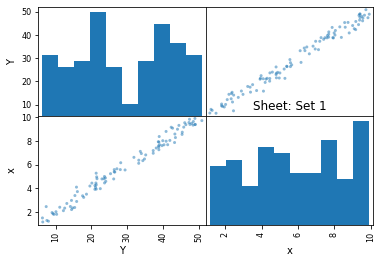

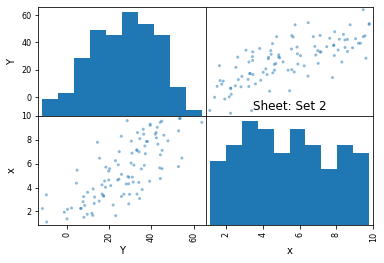

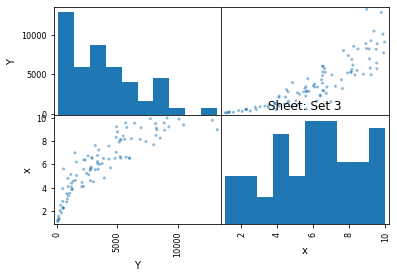

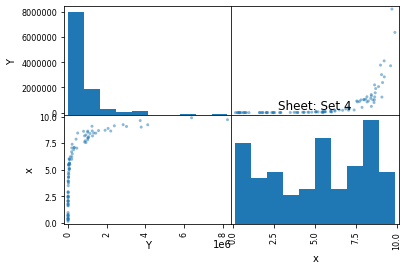

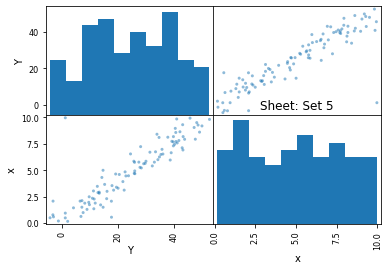

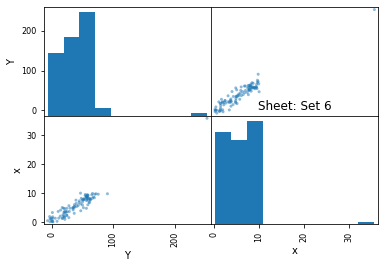

In [22]:
scatr_matr(create_dfs(xl))

# Visual Linearity Check - Conclusion:

From visual inspection of the scatter matrix plots the spreedsheets that have a linear correlation are: Set 1, Set 2, Set 5, and Set 6. For quantitative assurance, the correlation matrix shows that Set 2, 3, and 4 are the least linear with a pearson R^2 < 0.88. However, taking into account the scatter plots and the correlation matrix, Set 3 and 4 seem to be the most divergent from linear. As such the data transformations will be done on Set 3 and 4.

Below is the correlation matrix of the transformed datasets of Set 3 and 4:

In [23]:
corr_matr(create_dfs(xl))

{'Set 1': [          Y         x
  Y  1.000000  0.989468
  x  0.989468  1.000000],
 'Set 2': [          Y         x
  Y  1.000000  0.745168
  x  0.745168  1.000000],
 'Set 3': [          Y         x
  Y  1.000000  0.869031
  x  0.869031  1.000000],
 'Set 4': [          Y         x
  Y  1.000000  0.616155
  x  0.616155  1.000000],
 'Set 5': [          Y         x
  Y  1.000000  0.897892
  x  0.897892  1.000000],
 'Set 6': [          Y         x
  Y  1.000000  0.955578
  x  0.955578  1.000000]}

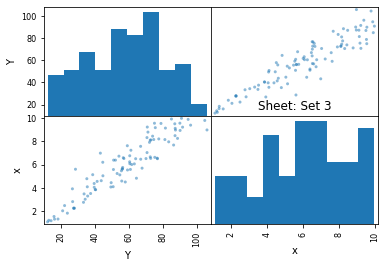

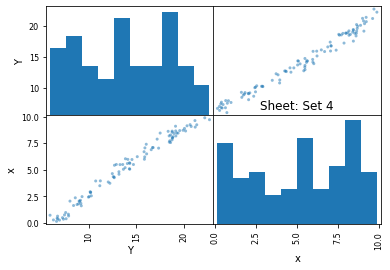

In [24]:
scatr_matr(trans_df(create_dfs(xl)))

In [25]:
sum_stats_dfs_new, sum_stats_df_trans_new, dfs_new, df_trans_new = ex_func(xl)

# OLS Regression Plots and Corresponding Summary Statistics:

## For untransformed data:

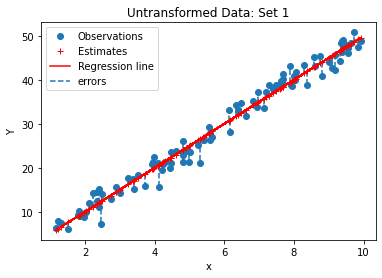

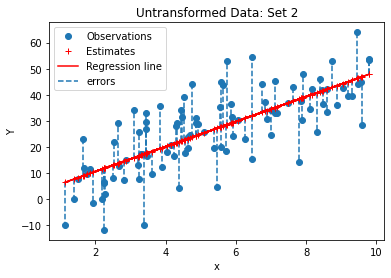

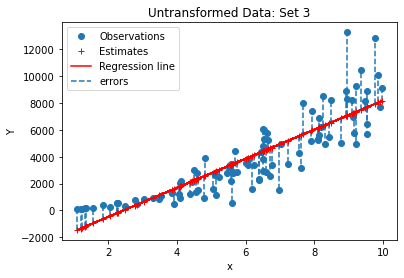

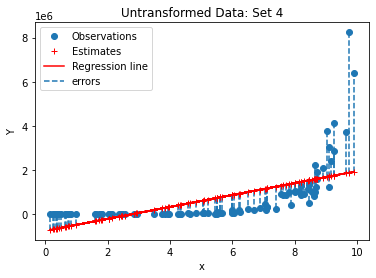

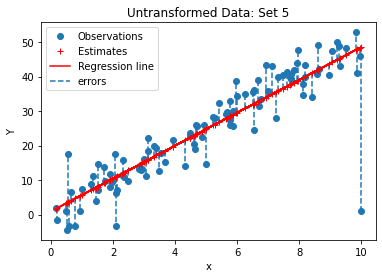

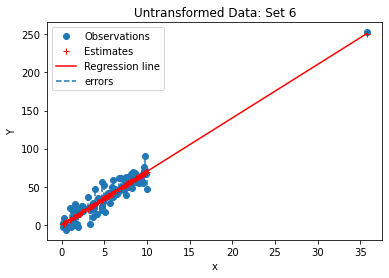

In [26]:
plotter(dfs_new, True)

## For transformed data:

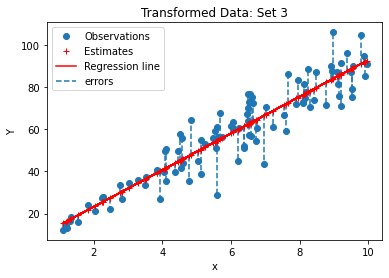

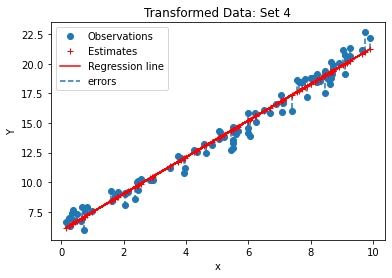

In [27]:
plotter(df_trans_new, False)

## Summary statistics for each linear model

### For untransformed data:

In [28]:
sum_stats_dfs_new

['Set 1',
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      Y   R-squared:                       0.979
 Model:                            OLS   Adj. R-squared:                  0.979
 Method:                 Least Squares   F-statistic:                     4579.
 Date:                Tue, 08 Jun 2021   Prob (F-statistic):           4.47e-84
 Time:                        21:19:48   Log-Likelihood:                -206.03
 No. Observations:                 100   AIC:                             416.1
 Df Residuals:                      98   BIC:                             421.3
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------------------------------

### For transformed set:

In [29]:
sum_stats_df_trans_new

['Set 3',
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      Y   R-squared:                       0.868
 Model:                            OLS   Adj. R-squared:                  0.866
 Method:                 Least Squares   F-statistic:                     641.8
 Date:                Tue, 08 Jun 2021   Prob (F-statistic):           8.32e-45
 Time:                        21:19:48   Log-Likelihood:                -353.39
 No. Observations:                 100   AIC:                             710.8
 Df Residuals:                      98   BIC:                             716.0
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------------------------------

## Transformation conclusions
After transforming the non-linear datasets 3 and 4, there were significant changes to the slope, intercept and $R^2$ values. The $R^2$ values improved to having more than 80% of the data fitting to the linear model whereas before the transformations the data were less than 80% fitted to the linear model. 


# Residual based conclusions:

## Histogram plots of residuals and corresponding summary statistics for each untransformed set:

Set 1 [count    1.000000e+02
mean     5.782042e-15
std      1.908727e+00
min     -3.763343e+00
25%     -1.472735e+00
50%     -2.630865e-01
75%      1.133296e+00
max      5.254912e+00
Name: Residuals, dtype: float64]


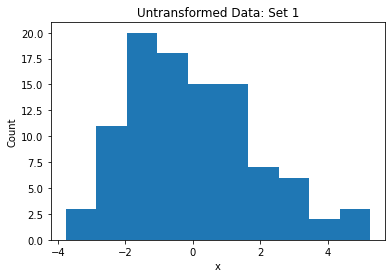

Set 2 [count    1.000000e+02
mean    -1.332268e-14
std      1.041688e+01
min     -2.427189e+01
25%     -6.825796e+00
50%      3.255999e-01
75%      6.370633e+00
max      2.713100e+01
Name: Residuals, dtype: float64]


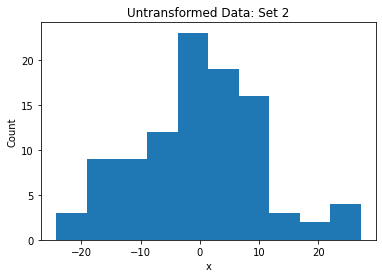

Set 3 [count    1.000000e+02
mean     4.865797e-13
std      1.505310e+03
min     -6.202119e+03
25%     -9.320867e+02
50%      1.251402e+02
75%      8.943890e+02
max      3.406664e+03
Name: Residuals, dtype: float64]


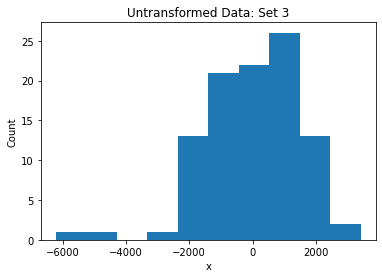

Set 4 [count    1.000000e+02
mean    -2.956949e-10
std      1.033103e+06
min     -6.364011e+06
25%     -3.134527e+05
50%      3.081833e+05
75%      6.187548e+05
max      1.039076e+06
Name: Residuals, dtype: float64]


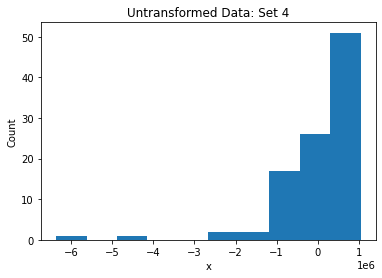

Set 5 [count    1.010000e+02
mean     1.477366e-15
std      6.666383e+00
min     -1.403782e+01
25%     -3.542946e+00
50%     -1.164350e+00
75%      2.449717e+00
max      4.742030e+01
Name: Residuals, dtype: float64]


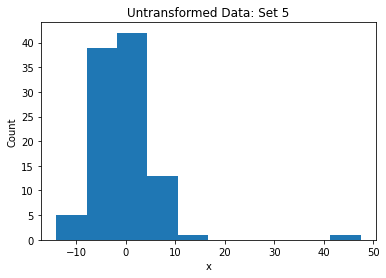

Set 6 [count    1.010000e+02
mean    -1.361287e-14
std      9.252081e+00
min     -2.329843e+01
25%     -5.543791e+00
50%      3.559015e-01
75%      5.103361e+00
max      2.305339e+01
Name: Residuals, dtype: float64]


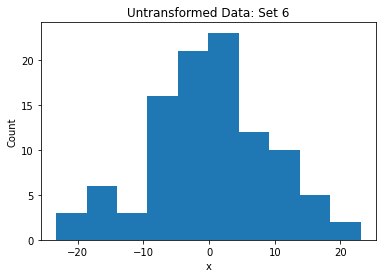

In [30]:
res_plotter(res(dfs_new), True)

Based on all the histogram plots above, other than Set 3 and 4, the distributions are normal (centered around zero). The mean for each set have orders of magnitude much less than -10 and thus are close to zero. The averages being close to zero means the deviation of the estimates from the actual is relatively small.

## Histogram plots of residuals and corresponding summary statistics for each transformed set:

Set 3 [count    1.000000e+02
mean     4.865797e-13
std      1.505310e+03
min     -6.202119e+03
25%     -9.320867e+02
50%      1.251402e+02
75%      8.943890e+02
max      3.406664e+03
Name: Residuals, dtype: float64]


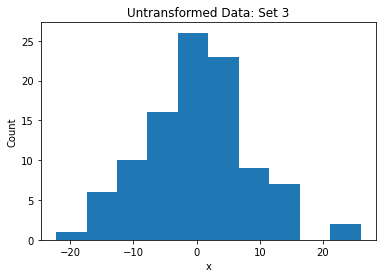

Set 4 [count    1.000000e+02
mean    -2.956949e-10
std      1.033103e+06
min     -6.364011e+06
25%     -3.134527e+05
50%      3.081833e+05
75%      6.187548e+05
max      1.039076e+06
Name: Residuals, dtype: float64]


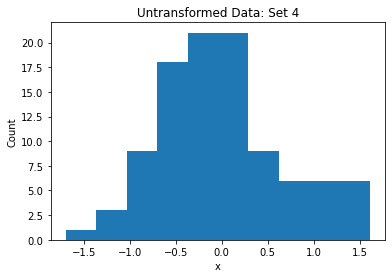

In [31]:
res_plotter(res(df_trans_new), True)

For transformed datasets 3 and 4, the distributions are normal (centered around zero). The mean for each set have orders of magnitude much less than -10 and thus are close to zero. 

## $R^2$ conclusions between estimates and original data values :

In [32]:
# R2 of the untransformed data
esti_R2(dfs_new)

{'Set 1': [0.9894680422580039],
 'Set 2': [0.7451678444513642],
 'Set 3': [0.869031161933603],
 'Set 4': [0.6161549853932714],
 'Set 5': [0.8978916807640095],
 'Set 6': [0.9555780958523353]}

In [33]:
# R2 of the transformed data
esti_R2(df_trans_new)

{'Set 3': [0.9314103026219617], 'Set 4': [0.9893146503263649]}

### RMSE conclusions between estimates and original data values :

In [34]:
rmse_dict, nor_rmse_dict = rmse_func(dfs_new)

In [35]:
rmse_dict  # RMSE of untransformed data

{'Set 1': [1.8991591177615381],
 'Set 2': [10.364662729373002],
 'Set 3': [1497.7650258233175],
 'Set 4': [1027924.1597931638],
 'Set 5': [6.633298877895997],
 'Set 6': [9.206164916327252]}

In [36]:
nor_rmse_dict    # Normalized RMSE of untransformed data

{'Set 1': [0.06505481417766443],
 'Set 2': [0.3871064804741499],
 'Set 3': [0.3886418892014987],
 'Set 4': [1.5540634215576272],
 'Set 5': [0.26920051501234127],
 'Set 6': [0.2349817776969611]}

Above are the RMSE and normalized RMSE of the untransformed data. The RMSE shows on average by how much the y estimates are from the original data. For sets 1, 2, 5, and 6 the predictions were not as off. As a result for sets 1, 2, 5, and 6, the estimates were 6.50%, 38.7%, 26.9%, and 23.5% off from the mean for each untransformed dataset, respectively.

For sets 3 and 4, the estimates are off by 4 or more orders of magnitude, with set 4 having the worst estimates. Set 4 has a 155% deviation from the mean whereas set 3 has a 38.9%.

In [37]:
rmse_dict_trans, nor_rmse_dict_trans \
= rmse_func(df_trans_new)

In [38]:
rmse_dict_trans       # RMSE of transformed data

{'Set 3': [8.289216154489305], 'Set 4': [0.6774483143585726]}

In [39]:
nor_rmse_dict_trans   # Normalized RMSE of transformed data

{'Set 3': [0.14274200474202622], 'Set 4': [0.04833812292485428]}

Above are the RMSE and normalized RMSE of the transformed data. For sets 3 and 4 the predictions were not as off which corresponds to the estimates being only 14.3% and 4.83% off from the mean of each transformed dataset, respectively. 

Compared to the untransformed dataset for set 3 and 4, the transformed data has much better estimates than not transforming. 

# Find outliers, remove them, and graph them:

## Find Outliers

### For untransformed data

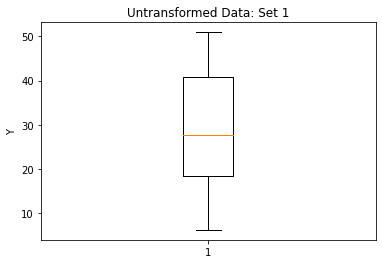

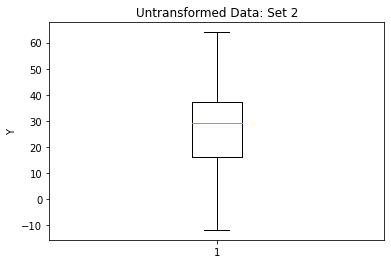

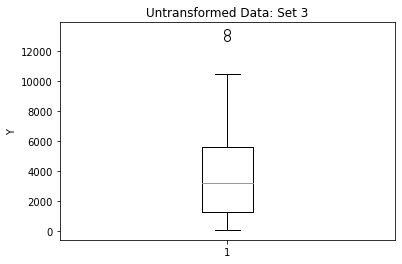

Outliers: [12858.59926684 13259.10996988]


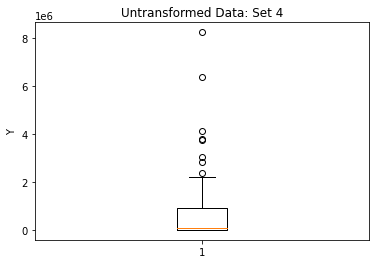

Outliers: [3729063.77884434 3022129.66356603 8240777.31251081 2392947.33224861
 4118015.36892519 3780735.95430427 6384378.83258088 2847207.57732108]


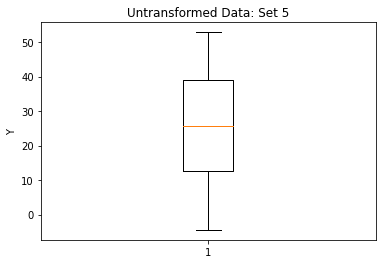

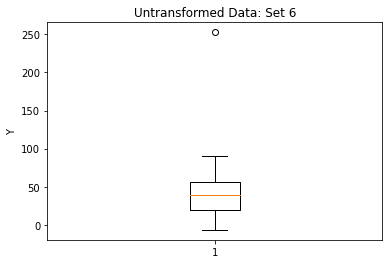

Outliers: [252.83789722]


In [40]:
outliers = box_plotter(dfs_new, True)

### For transformed data

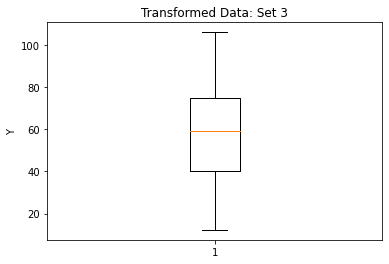

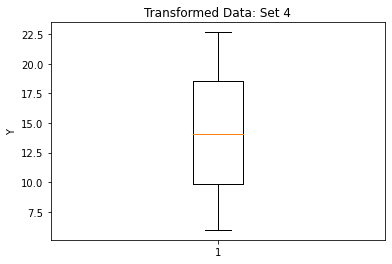

In [41]:
outliers_trans = box_plotter(df_trans_new, False)

In [42]:
outlier_indices = outlier_loc(outliers)

## Summary of finding outliers:

As shown above, the only outliers present are in three sets: Set 3, 4, and 6

## Remove them:

In [43]:
# for untransformed data
dfs_new_no_outliers = remove_outliers(outlier_indices, dfs_new)

In [44]:
# remove the set that is not transformed
outlier_indices_trans = {key:val for key, val in outlier_indices.items() if key != 'Set 6'}

# for transformed data
df_trans_new_no_outliers = remove_outliers(outlier_indices_trans, df_trans_new)

## Graph them:

#### For untransformed data:

In [45]:
# get summary stats for corresponding new dfs with no outliers
m_dfs_new_no_outliers = model(dfs_new_no_outliers)
sum_stats_dfs_new_no_outliers = sum_stats(m_dfs_new_no_outliers)

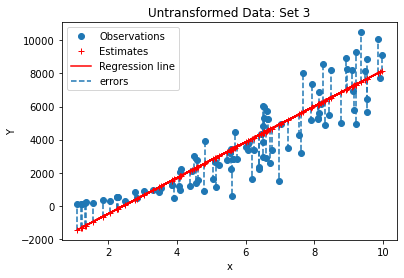

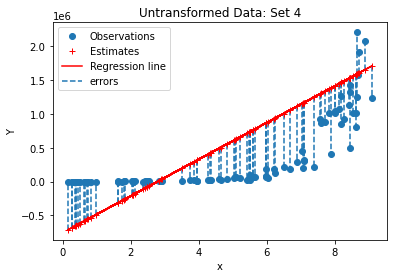

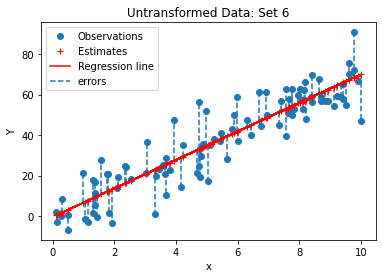

In [46]:
plotter(dfs_new_no_outliers, True)

In [47]:
# summary stats for above graphs
sum_stats_dfs_new_no_outliers

['Set 3',
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      Y   R-squared:                       0.788
 Model:                            OLS   Adj. R-squared:                  0.785
 Method:                 Least Squares   F-statistic:                     356.1
 Date:                Tue, 08 Jun 2021   Prob (F-statistic):           4.56e-34
 Time:                        21:19:52   Log-Likelihood:                -839.38
 No. Observations:                  98   AIC:                             1683.
 Df Residuals:                      96   BIC:                             1688.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------------------------------

#### For transformed data:

There is no need to remove outliers in the transformed data as there are no outliers

## Conclusion of above plots:
For Untransformed Set 3, before removing the outliers the $R^2$ was 75.5% and after removing the outleirs the $R^2$ became 78.8%. For Untransformed Set 4, before removing the outliers the $R^2$ was 38.0% and after removing the outleirs the $R^2$ became 55.6%. For Untransformed Set 6, before removing the outliers the $R^2$ was 91.3% and after removing the outleirs the $R^2$ became 83.7%. All these changes in $R^2$ due to removing the outliers corresponds to a 4.37% and 46.3% improvment for untransformed sets 3 and 4. However, for Set 6 it was not an improvement if only the $R^2$ is being analyzd. But looking at the linear plot for Set 6 before removing the outlier, the outlier falls far away from the rest of the dataset and thus had a big influence on the high $R^2$. The decrease in $R^2$ after removing the outlier for Set 6 is still acceptable because now the $R^2$ is more representative of the majority data. 

For Set 3 and Set 4, it was determined before that the data was not linear. So removing the outliers for a non-linear dataset improved the $R^2$ slightly but not to acceptable values. In fact it still holds that transforming the data proved much better than just only removing the outliers. Also, after transforming the data, the outliers for the untransformed data were no long outliers and the result $R^2$ for the transformed data became more acceptable. 

In terms of the slope and intercept between removing and not removing the outliers, there were no significant changes in terms of order of magnitude differences. 

In conclusion, no general answer can be given on whether removing outliers improve summary statistics. Rather, removing outliers should be decided on a case by case basis to show and prove if there is some statistical significance to removing them. 